In [1]:
import json
import multiprocessing
import hashing.lsh_main as lsh
# import graph.graph_main as graph
import time
from pathlib import Path
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import graph.random_walk_ori as random_walk
import pandas as pd
import lshashpy3 as lshash
import math 
from scipy import stats

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)
# data = moving_avg(data, 200).tolist()


window = 3072

nTS = 3

In [2]:
# data = pd.read_csv('/localdata/ABench-IoT/Generation/gan/dcgan/Electric.csv')
# data = data['Electric'].tolist()
# df_segments = pd.read_csv('/localdata/ABench-IoT/Generation/gan/dcgan/fake_noise_23_raw_f3.txt', header = None)

data = pd.read_csv('/localdata/ABench-IoT/Generation/gan/dcgan_Sauerstoff/Sauerstoff.csv')
data = data['Sauerstoff'].tolist()
data = stats.zscore(np.array(data))
data = data.tolist()
# data = data[:window * 6 ]
len(data)

250379

In [3]:
df_segments = pd.read_csv('/localdata/ABench-IoT/Generation/gan/dcgan_Sauerstoff/fake_noise_23_raw_f3.txt', header = None)


## Filter GAN generated data

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3072/3072 [00:03<00:00, 960.71it/s]


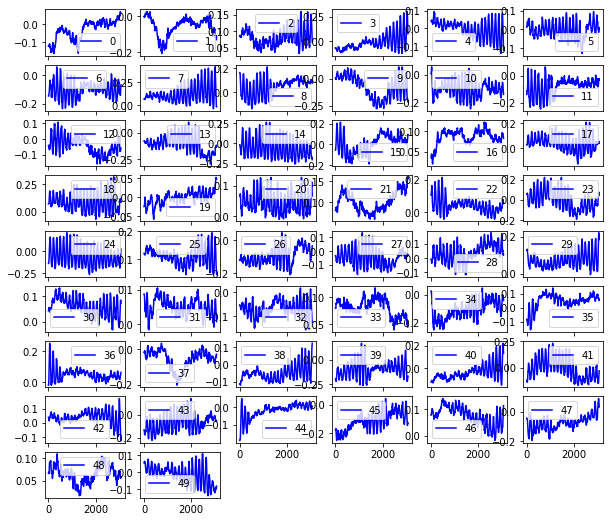

In [4]:
from scipy.signal import lfilter

df_segments = df_segments.T

n = 10  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1

for col in tqdm(df_segments):
#     plt.plot(df_segments[col].tolist())
    yy = lfilter(b,a,df_segments[col].tolist())
    yy[:n] = yy[n:n+1]
    df_segments[col] = yy.tolist()
#     plt.plot(df_segments[col].tolist())
#     plt.show()
    
    
# df_segments = pd.DataFrame(segments)
# df_segments = df_segments.T

df_segments.iloc[: , :50].plot(subplots=True, layout=(10,6), figsize=(10, 10), legend = True, color = 'b')
plt.show()

In [5]:
segments = [] 

for col in df_segments:
    segments += [df_segments[col].tolist()]
print(len(segments))

3072


# LSH

In [6]:
# def LSH_update(ori, generated, window, nTS, n_top = 30, hash_length = window // 300, num_hashtables=8):
#     # index synthetic segments
#     lsh = lshash.LSHash(hash_length, window, num_hashtables=num_hashtables)
#     for i in generated:
#         lsh.index(i) 
#     to_query = [ori[i:i + window] for i in range(0, len(ori) - window, window)]
#     lsh_res = []
#     used = 0
#     k = int(window * .03)
#     for i in tqdm(range(nTS)):
#         temp = list(random.choice( lsh.query(to_query[0], distance_func="euclidean", num_results=n_top))[0][0])
#         for i in range(1, len(to_query)): 
#             candidates = lsh.query(to_query[i], distance_func="euclidean", num_results=n_top)
#             s = list(random.choice(candidates)[0][0])
#             temp_t = temp[-k:]
#             s_h = s[:k]
#             overlap = []
#             for i in range(-k//2, k//2):
#                 overlap.append((1 - sigmoid(i))*temp_t[i + k//2] + sigmoid(i)*s_h[i + k//2])
#     #         for i in range(-1*k , 0):
#     #             temp[i]= (1 - sigmoid(i))*temp_t[i] + sigmoid(i)*s_h[i]
#     #         for i in range(0, k):
#     #             s[i]= (1 - sigmoid(i))*temp_t[i] + sigmoid(i)*s_h[i]
#             temp[-k:] = overlap
#             s[:k] = overlap[::-1]
#             temp.extend(s)
#             used += 1
#         lsh_res.append(temp)
#         print(used, len(generated)*50//100)
#         if used > len(generated)*50//100: 
#             lsh = lshash.LSHash(hash_length, window, num_hashtables=num_hashtables)
#             for i in generated:
#                 lsh.index(i)    
#             used = 0
#     return lsh_res

def LSH(ori, generated, window, nTS, n_top = 30, hash_length = window // 300, num_hashtables=8, ts_length = -1):
    if ts_length == -1: 
        ts_length = len(ori)
    else:
        ts_length -= ts_length%len(ori)
    # index synthetic segments
    lsh = lshash.LSHash(hash_length, window, num_hashtables=num_hashtables)
    for i in generated:
        lsh.index(i) 
    to_query = [ori[i%(len(ori)-window):i%(len(ori)-window) + window] for i in range(0, ts_length - window, window)]
    lsh_res = []
    k = int(window * .03)
    for i in tqdm(range(nTS)):
        temp = list(random.choice( lsh.query(to_query[0], distance_func="euclidean", num_results=n_top))[0][0])
        for i in range(1, len(to_query)): 
#             print(len(to_query[i]))
            candidates = lsh.query(to_query[i], distance_func="euclidean", num_results=n_top)
            s = list(random.choice(candidates)[0][0])
            temp_t = temp[-k:]
            s_h = s[:k]
            overlap = []
            for i in range(-k//2, k//2):
                overlap.append((1 - sigmoid(i))*temp_t[i + k//2] + sigmoid(i)*s_h[i + k//2])
    #         for i in range(-1*k , 0):
    #             temp[i]= (1 - sigmoid(i))*temp_t[i] + sigmoid(i)*s_h[i]
    #         for i in range(0, k):
    #             s[i]= (1 - sigmoid(i))*temp_t[i] + sigmoid(i)*s_h[i]
            temp[-k:] = overlap
            s[:k] = overlap[::-1]
            temp.extend(s)
        lsh_res.append(temp)
    return lsh_res

# lsh_res= LSH(data, segments, window, nTS)


# Graph

In [7]:
#Calculates the distance between two series. Given series A, B returns the Euclidean distance between A and B
def distance(a, b):
    return np.sqrt(np.sum((a - b)**2))
    
#The probability is converted according to the sorted distances, which adds up to 1
def distopro(a):
    a=len(a)
    if(a==3):
        b=[0.2,0.3,0.5]
    elif(a==4):
        b=[0.1,0.2,0.3,0.4]
    else:
        b=[0.04,0.12,0.2,0.28,0.36]
    return np.array(b)
        

#Input is the original data matrix, return is the relationship matrix relation_matrix, and probability matrix probability_matrix
#Data is the matrix of series, the first dimension is the number of series, and the second dimension is each series
#Window_size is the size of the window to calculate the distance, and k is the number of the nearest neighbors selected. Currently, 3,4,5 are supported
def transform(data, window_size, k):
    numOfSeq=data.shape[0]
    distance_matrix=np.ones([numOfSeq,numOfSeq],dtype = float)
    for i in range(numOfSeq):
        for j in range(numOfSeq):
            distance_matrix[i][j]=distance(data[i,data.shape[1]-window_size:],data[j,0:window_size])
    relation_matrix=np.ones([numOfSeq,k],dtype = int)
    subdistance_matrix=np.ones([numOfSeq,k],dtype = float)
    probability_matrix=np.ones([numOfSeq,k],dtype = float)
    for i in range(numOfSeq):
        relation_matrix[i]=distance_matrix[i].argsort()[::-1][data.shape[0]-k:]
        #print(relation_matrix[i])
#     print(relation_matrix[i])
    for i in range(numOfSeq):
        for j in range(k):
            subdistance_matrix[i][j]=distance_matrix[i][relation_matrix[i][j]]
    
    for i in range(numOfSeq):
        probability_matrix[i]=distopro(subdistance_matrix[i])
    
    
    return distance_matrix, subdistance_matrix ,relation_matrix, probability_matrix
            
      
#print(transform(np.array([[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,0]]), 2, 3))


#Given the ID of the current series, the ID of the next series is generated randomly according to probability
def next_step(relation_array, probability_array):
    value=random.random()
#     print(value)
    threshold=[0]
    sum_value=0
    for i in range(len(probability_array)):
        sum_value=sum_value+probability_array[i]
        threshold.append(sum_value)
    for i in range(len(threshold)-1):
        if(value>threshold[i] and value<=threshold[i+1]):
            return relation_array[i]

#Given a relation matrix and a probability matrix, returns a series of length        
def random_walk(relation_matrix, probability_matrix, length):
    seq=[0]
    temp_id=0
    for i in range(length-1):
        temp_id=next_step(relation_matrix[temp_id],probability_matrix[temp_id])
        seq.append(temp_id)
        #print(temp_id)
    return np.array(seq)


def Graph(ori, generated, window, nTS, ts_length = -1):
    if ts_length == -1: 
        ts_length = len(ori)
    a,b,c,d=transform(np.array(generated), 100, 5)
    graph_res = []
    for i in range(nTS):
        path = random_walk( c, d, ts_length//window)
#         print(path)
        temp=[]
        for s in path:
    #         print(path[i], i)
            temp+=list(generated[s])
        graph_res.append(temp)
#     print(len(graph_res))   
    return graph_res
    
# def Graph_update(ori, generated, window, nTS):
#     a,b,c,d=transform(np.array(generated), 100, 5)
#     used = 0
#     graph_res = []
#     for i in range(nTS):
#         path = random_walk( c, d, int(len(ori)/window))
# #         print(path)
#         temp=[]
#         for s in path:
#     #         print(path[i], i)
#             temp+=list(generated[s])
#             used +=1
#         graph_res.append(temp)
#         print(used, len(generated)*50//100)
#         if used > len(generated)*50//100: 
#             a,b,c,d=transform(np.array(generated), 100, 5)
#             used = 0
# #         print(len(graph_res))   
#     return graph_res
    

# Generate LSH

In [8]:
nTS = 100
ts_length = 5200000



In [9]:
start = time.time()
lsh_res= LSH(data, segments, window, nTS=nTS, ts_length = ts_length)
lsh_res = [i[:5200000] for i in lsh_res]
print('LSH runtime: ', time.time() - start)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [5:42:12<00:00, 205.33s/it]


LSH runtime:  20544.760380506516


In [10]:
df = pd.DataFrame(lsh_res)
df = df.T


In [ ]:
df.T.to_csv("d1_lsh.csv", sep=',', float_format='%.6f', header=True, index=False)


In [14]:
df.T.to_csv("d1_lsh.csv", sep=',', float_format='%.6f', header=False, index=False)

In [17]:
df = pd.concat([df for i in range(2)], axis=0)[:5184000]
df.columns = ['s' + str(i) for i in range(100)]
df.to_csv("d1_lsh.csv", sep=',', float_format='%.6f', header=True, index=False)

In [18]:
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm

nb_station = 10
nb_sensor = 100
nb_days = 60
granularity = 10 #seconds

dtime = datetime(2019, 3, 1, 00)
dtimestamp = datetime.timestamp(dtime)
ms = int(round(dtimestamp * 1000))
n_it = 10
print(ms)

list_time = [datetime.fromtimestamp(int((ms + i * granularity * 1000) //1000)).strftime('%Y-%m-%dT%H:%M:%S') for i in range(86400 // granularity * nb_days)] * 10

print(len(list_time))

list_st = []
for s in range(10):
    list_st += ['st' + str(s) for i in range(86400 // granularity * nb_days)]
df['time'] = list_time
df['id_station'] = list_st
df = df[['time','id_station']+['s'+str(i) for i in range(100)]]
df

1551398400000
5184000


,time,id_station,s0,s1,s2,s3,s4,s5,s6,s7,...,s90,s91,s92,s93,s94,s95,s96,s97,s98,s99
0,2019-03-01T00:00:00,st0,0.072316,0.060267,0.057644,0.074695,0.079925,0.060259,0.060267,0.033656,...,0.074695,0.074695,0.073763,0.068566,0.062779,0.067098,0.057644,0.062779,0.041223,0.107864
1,2019-03-01T00:00:10,st0,0.072316,0.060267,0.057644,0.074695,0.079925,0.060259,0.060267,0.033656,...,0.074695,0.074695,0.073763,0.068566,0.062779,0.067098,0.057644,0.062779,0.041223,0.107864
2,2019-03-01T00:00:20,st0,0.072316,0.060267,0.057644,0.074695,0.079925,0.060259,0.060267,0.033656,...,0.074695,0.074695,0.073763,0.068566,0.062779,0.067098,0.057644,0.062779,0.041223,0.107864
3,2019-03-01T00:00:30,st0,0.072316,0.060267,0.057644,0.074695,0.079925,0.060259,0.060267,0.033656,...,0.074695,0.074695,0.073763,0.068566,0.062779,0.067098,0.057644,0.062779,0.041223,0.107864
4,2019-03-01T00:00:40,st0,0.072316,0.060267,0.057644,0.074695,0.079925,0.060259,0.060267,0.033656,...,0.074695,0.074695,0.073763,0.068566,0.062779,0.067098,0.057644,0.062779,0.041223,0.107864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176635,2019-04-29T23:59:10,st9,-0.194998,-0.073781,-0.139961,-0.148012,-0.152862,-0.114967,-0.167816,-0.114967,...,-0.157352,-0.114923,-0.095940,-0.146962,-0.113105,-0.040510,-0.152862,-0.046392,-0.065319,-0.114967
176636,2019-04-29T23:59:20,st9,-0.199029,-0.075806,-0.144498,-0.152446,-0.154132,-0.119421,-0.172192,-0.119421,...,-0.160281,-0.116955,-0.098194,-0.148089,-0.113497,-0.040501,-0.154132,-0.045316,-0.065788,-0.119421
176637,2019-04-29T23:59:30,st9,-0.203143,-0.078855,-0.148820,-0.157017,-0.155545,-0.124012,-0.176776,-0.124012,...,-0.163923,-0.119592,-0.099814,-0.150096,-0.115270,-0.041307,-0.155545,-0.044531,-0.066725,-0.124012
176638,2019-04-29T23:59:40,st9,-0.203466,-0.081189,-0.152231,-0.161690,-0.156122,-0.126600,-0.181113,-0.126600,...,-0.167537,-0.121647,-0.102775,-0.149697,-0.115917,-0.040850,-0.156122,-0.044452,-0.067593,-0.126600


In [19]:
df.to_csv("d1_lsh.csv", sep=',', float_format='%.6f', header=True, index=False)

# Generate Graph

In [ ]:
# Graph

start = time.time()
graph_res = Graph(data, segments, window, nTS=nTS, ts_length = ts_length)
for i in range(len(graph_res)):
    for j in range(len(graph_res[i])):
        graph_res[i][j] = abs(graph_res[i][j])
print('Graph runtime: ', time.time() - start, 's')


In [ ]:
len(graph_res[0])

In [ ]:
pd.DataFrame(graph_res)


In [ ]:
# graph_res = [abs(i[:5184000]) for i in graph_res]


In [ ]:
import itertools
graph_res_ALL = list(itertools.chain.from_iterable(graph_res))
print(len(graph_res_ALL))

In [ ]:
df_graph = pd.DataFrame()
for i in range(100):
    df_graph['s' + str(i)] = list(itertools.chain.from_iterable([graph_res[i*10 + idx] for idx in range(10)]))  #graph_res_ALL[i*5184000:(i+1)*5184000]
df_graph.head()

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm

nb_station = 10
nb_sensor = 100
nb_days = 60
granularity = 10 #seconds

dtime = datetime(2019, 3, 1, 00)
dtimestamp = datetime.timestamp(dtime)
ms = int(round(dtimestamp * 1000))
n_it = 10
print(ms)

list_time = [datetime.fromtimestamp(int((ms + i * granularity * 1000) //1000)).strftime('%Y-%m-%dT%H:%M:%S') for i in range(86400 // granularity * nb_days)] * 10

print(len(list_time))

list_st = []
for s in range(10):
    list_st += ['st' + str(s) for i in range(86400 // granularity * nb_days)]
df['time'] = list_time
df['id_station'] = list_st
df = df[['time','id_station']+['s'+str(i) for i in range(100)]]
df

In [ ]:
df.to_csv("d1_lsh.csv", sep=',', float_format='%.6f', header=True, index=False)